In [14]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import json
import urllib.request
import cv2
import torchvision.datasets as datasets
from torch.utils.data import DataLoader,Dataset
import math

In [15]:
#Opening the JSON files and saving the data
with open("c:/Users/sinam/Desktop/label.json", "r") as myfile :
    data = myfile.read()
data = json.loads(data)
len(data)

698

In [16]:
#Removing the images that have no labels
def Remove_Unlabeled_Images(data):
    #all =  correctly labeled images
    all = []
    for x in range(len(data)):
        if data[x]["Label"] != {}:
            all.append(data[x])
    return all

all = Remove_Unlabeled_Images(data)

In [31]:
# Pulling the images from labelbox server and saving them on PC  with accurate ID
train = []
store_path = "c:/Users/sinam/PycharmProjects/SoftwareProject/biene/train/ventilator/"
for x in range(len(all)):
    url = all[x].get("Labeled Data")
    id = all[x].get("ID")
    url_response = urllib.request.urlopen(url)
    # Storing on PC in the folder we have selected
    urllib.request.urlretrieve(url, "c:/Users/sinam/PycharmProjects/SoftwareProject/biene/train/ventilator/{}.jpg".format(id))


    print(x)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


KeyboardInterrupt: 

In [21]:
#This section estraxts the label details and coordinats of each label line.

imgs = []
for x in range(len(all)):
    label = all[x]["Label"]["objects"]
    punkte = np.empty(0)
    for i in range(len(label)):

        for key in label[i]:
            if key == "line":
                punkt = label[i].get("line")
                for i in range(len(punkt)):
                    x = punkt[i].get("x")
                    y = punkt[i].get("y")
                    line = [x,y]
                    punkte = np.append(punkte, line)
    imgs.append(punkte)

#It saves all the point coordinates (x,y) of each image in an array

points = np.array(imgs)

#Each 4 coordinates written in a batch shows the (x,y) coordinates of two dots that define a line

for i in range(points.shape[0]):
    points[i] = (points[i].reshape(int(points[i].shape[0] / 4),4))
print(points[:5])

[array([[2159.1  ,  960.447, 2091.767, 1070.447],
       [1347.1  ,  812.114, 1356.6  ,  940.114]])
 array([[1242.017, 1245.577, 1226.866, 1354.668],
       [1344.567,  822.396, 1365.901,  928.396],
       [ 659.927, 1963.248,  639.261, 2080.581],
       [2051.185, 1113.222, 2011.185, 1243.888]])
 array([[ 812.274,  830.325,  805.054,  938.628],
       [1259.928, 1628.159, 1227.437, 1722.022],
       [ 693.141, 1927.798,  664.26 , 2050.542],
       [2090.253, 1140.794, 2014.44 , 1223.827],
       [2148.014,  978.339, 2072.202, 1050.542],
       [1148.014,  700.361, 1122.744,  823.105],
       [1256.318, 1256.318, 1205.776, 1361.011]])
 array([[1252.675, 1251.39 , 1220.675, 1349.39 ],
       [ 748.675, 1947.39 ,  734.675, 2055.39 ],
       [ 806.675,  821.39 ,  806.675,  939.39 ],
       [1142.151,  710.301, 1120.939,  825.452],
       [2158.845,  967.509, 2097.473, 1079.422],
       [2046.931, 1126.354, 2007.22 , 1238.267]])
 array([[1249.741, 1239.778, 1225.741, 1349.778],
       [ 80

In [22]:
# These points that are entered are manually entered as examples!
# We need to re-write this entire section in a way that we convert
# the label line into a bounding box!

p1 = np.array([1347.1  ,  812.114])
p2 = np.array([1356.6  ,  940.114])


v = [p1[0]- p2[0], p1[1]- p2[1]]
wy = np.sqrt(1 / (1 + ( ((p1[1] - p2[1]) / (p1[0] - p2[0]))**2)))
wx = - (wy * ( p1[1] - p2[1])) / (p1[0] - p2[0])
w_ = np.array([wx, wy])
w = np.sqrt(w_[0]**2 + w_[1]**2)
wu = [w_[0]/w, w_[1]/w]
dx = (120 / 2) * wu[0]
dy = (120/ 2) * wu[1]
P_1=[p1[0]+dx,p1[1]+dy]
P_2=[p1[0]-dx,p1[1]-dy]
P_3=[p2[0]+dx,p2[1]+dy]
P_4=[p2[0]-dx,p2[1]-dy]
x = P_4[0]
y = P_4[1]
print(P_1, P_2, P_3, P_4)
height = np.sqrt(((P_1[0]- P_2[0])**2 + (P_1[1]- P_2[1])**2))
width = np.sqrt(((P_1[0]- P_3[0])**2 + (P_1[1]- P_3[1])**2))


height_l = p2[1]- p1[1]
width_l =  p2[0]- p1[0]

theta = math.atan(height_l/width_l)
print(theta)
theta = math.degrees(theta)
print(theta)
theta = 180 - (abs(theta) + 90)
print("gama", theta)

[1287.2645730931495, 816.5549105907428] [1406.9354269068504, 807.6730894092573] [1296.7645730931495, 944.5549105907428] [1416.4354269068504, 935.6730894092573]
1.496713404245863
85.75536120394581
gama 4.244638796054176


In [26]:
#Here we read the addresses of the images
# and divide our images into valid and training sets

from glob import glob
files =[]
DATA_DIR = "c:/Users/sinam/PycharmProjects/SoftwareProject/biene/"
train_dir = f"{DATA_DIR}train/"
files = glob(f'{DATA_DIR}train/*/*.jpg')
# for i in range( len(all)):
#   for py in enumerate(glob(f'{DATA_DIR}train/*/%i.jpg'%i)):
#        files.append(py[1])

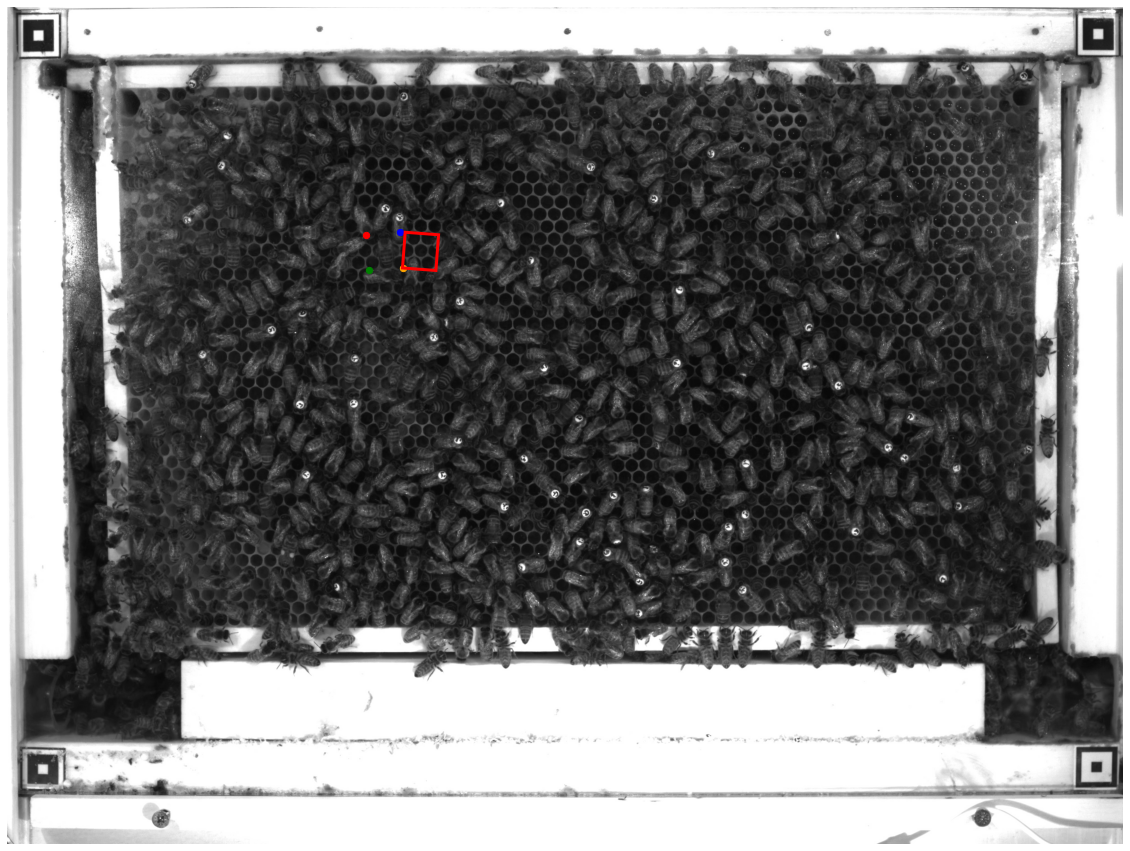

In [27]:
#This block of code is used to show the bounding box that we have calculated.
# It shows the points correctly but it cannot show the bounding box itself
# correctly due to misccalculating the angle
im = cv2.imread(files[100])
rect = plt.Rectangle((x, y), width, height, color="red", fill=False, lw=3,angle=-90+theta)
plt.figure(figsize=(20, 20))
plt.axis('off')
plt.imshow(im)
plt.scatter(x=[P_1[0]], y=[P_1[1]],c='r', s=40)
plt.scatter(x=[P_2[0]], y=[P_2[1]],c='blue', s=40)
plt.scatter(x=[P_3[0]], y=[P_3[1]],c='green', s=40)
plt.scatter(x=[P_4[0]], y=[P_4[1]],c='orange', s=40)
plt.gca().add_patch(rect)
plt.show()



In [28]:
#This section scales the images down and makes them smaller
# (It also scaled down the labels accurately along with the image).
#This is a test to show and see if we have read and extracted the points correctly

m = cv2.imread(files[100])

w, h = m.shape[0], m.shape[1]
print(w,h)

w_scale = 1000 / w
h_scale = 1000 / h
m = cv2.resize(m, (1000,1000))
pts = points[100]

for i in range(len(pts)):
    for j in range(4):
        if j == 0 or j == 2:
            pts[i][j] = pts[i][j] * h_scale
        else:
            pts[i][j] = pts[i][j] * w_scale
#pts = pts[i].reshape(-1,2)
print(pts)



pts = pts.reshape(-1,2)
print(len(pts))
print(pts)

for i in range(1, len(pts)+1):
    if i % 2 == 0:
        cv2.polylines(m, np.int32([pts[i-2:i]]) ,isClosed=False,color = (0, 0, 255), thickness=1)


cv2.imshow("sina", m)
cv2.waitKey(0)
cv2.destroyAllWindows()


3000 4000
[[312.7535     413.23       306.087      450.119     ]
 [200.4885     269.819      203.5005     310.783     ]
 [512.53675    375.04       507.115      407.16833333]
 [336.96275    272.245      341.46275    308.91166667]]
8
[[312.7535     413.23      ]
 [306.087      450.119     ]
 [200.4885     269.819     ]
 [203.5005     310.783     ]
 [512.53675    375.04      ]
 [507.115      407.16833333]
 [336.96275    272.245     ]
 [341.46275    308.91166667]]


In [102]:
# This section which is currently commented out is used to take a part
# of our training data and use it as validation data
# valid_dir = f"{DATA_DIR}valid/"
# from data_utils import create_validation_data
# import os
# if not os.path.exists(valid_dir):
#     create_validation_data(train_dir, valid_dir, split=0.2, ext='jpg')

100%|██████████| 89/89 [00:00<00:00, 428.00it/s]


445
89


In [20]:
# Here we define our datasets but this code is not working now :(

class BieneDataset(Dataset):
    def __init__(self, ds, points, sz=299):

        self.imgs = ds.imgs
        self.classes = ds.classes
        self.points = points
        self.sz = sz
        self.tfms = transforms.Compose([
            transforms.Resize((sz, sz)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        img, lbl = self.imgs[index]
        # get points
        pts = self.points[index]
        image = Image.open(img).convert('RGB')
        w, h = image.size
        w_scale = 1000 / w
        h_scale = 1000 / h

        # transformations
        image = self.tfms(image)

        for i in range(len(pts)):
            for j in range(4):
                if j == 0 or j == 2:
                    pts[i][j] = pts[i][j] * h_scale
                else:
                    pts[i][j] = pts[i][j] * w_scale

        # return image tensor, label tensor and bounding box tensor
        return image,lbl, torch.Tensor(pts)

    def __len__(self):
        return len(self.imgs)


In [21]:
# We break our data into batches and prepare it for feeding into network

train_data = datasets.ImageFolder(train_dir)
train_ds = BieneDataset(train_data, points, sz=299)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

# valid_data = datasets.ImageFolder(valid_dir)
# valid_ds = BieneDataset(valid_data, points, sz=299)
# valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=False)